In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.backend import square, mean
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, GRU, Embedding

In [3]:
include_weather_data = False

In [4]:
segment_speeds = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/segment-data/60-min-intervals/226255131.csv", sep=";")

if include_weather_data == True:
    wind_speed = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/weather data/smhi-weather-station-data-wind-speed.csv", sep=",")
    rain = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/weather data/smhi-weather-station-data-rain-amount.csv", sep=",")
    snow_depth = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/weather data/smhi-weather-station-data-snow-depth.csv", sep=",")
    temperature = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/weather data/smhi-weather-station-data-temperature.csv", sep=",")

In [5]:
if include_weather_data == True:
    wind_speed = wind_speed.loc[(wind_speed['Datum'] >= "2019-06-04")]
    rain = rain.loc[(rain['Datum'] >= "2019-06-04")]
    snow_depth = snow_depth.loc[(snow_depth['Datum'] >= "2019-06-04")]
    temperature = temperature.loc[(temperature['Datum'] >= "2019-06-04")]

In [6]:
segment_speeds.head(5)

,SegmentId,StartTime,EndTime,Speed
0,226255131,2019-06-03 00:00:00,2019-06-03 01:00:00,NaN
1,226255131,2019-06-03 01:00:00,2019-06-03 02:00:00,NaN
2,226255131,2019-06-03 02:00:00,2019-06-03 03:00:00,NaN
3,226255131,2019-06-03 03:00:00,2019-06-03 04:00:00,NaN
4,226255131,2019-06-03 04:00:00,2019-06-03 05:00:00,NaN


In [7]:
if include_weather_data == True:
    wind_speed.head(5)

In [8]:
if include_weather_data == True:
    rain.head(5)

In [9]:
if include_weather_data == True:
    snow_depth.head(5)

In [10]:
if include_weather_data == True:
    temperature.head(5)

# Preprocessing

Removing the first 24 records because the first 24 records are null values for traffic speed

In [11]:
segment_speeds = segment_speeds[24:]

Adding days and hours to the dataset because that could make it easier for it to identify what time instead of receiving a date column which is more complex.

In [12]:
pd.to_datetime(segment_speeds['StartTime'], format="%Y-%m-%d %H:%M:%S")
segment_speeds['hour'] = pd.DatetimeIndex(segment_speeds['StartTime']).hour
segment_speeds['day'] = pd.DatetimeIndex(segment_speeds['StartTime']).dayofyear
segment_speeds['year'] = pd.DatetimeIndex(segment_speeds['StartTime']).year

We now see now many null values are left

In [13]:
pd.isnull(segment_speeds).values.sum()

146

Interpolation is performed for those values that null which means we should have no null values anymore

In [14]:
segment_speeds = segment_speeds.interpolate(method='linear', limit_direction='forward', axis=0)

Now we merge the traffic speeds with the weather data and first need to put the segment speeds in same format as the weather data

In [15]:
if include_weather_data == True:
    pd.to_datetime(temperature['Datum'], format="%Y-%m-%d")
    pd.to_datetime(temperature['Tid (UTC)'], format="%H:%M:%S")
    temperature['hour'] = pd.DatetimeIndex(temperature['Tid (UTC)']).hour
    temperature['day'] = pd.DatetimeIndex(temperature['Datum']).dayofyear
    temperature['year'] = pd.DatetimeIndex(temperature['Datum']).year

    pd.to_datetime(rain['Datum'], format="%Y-%m-%d")
    pd.to_datetime(rain['Tid (UTC)'], format="%H:%M:%S")
    rain['hour'] = pd.DatetimeIndex(rain['Tid (UTC)']).hour
    rain['day'] = pd.DatetimeIndex(rain['Datum']).dayofyear
    rain['year'] = pd.DatetimeIndex(rain['Datum']).year

    pd.to_datetime(wind_speed['Datum'], format="%Y-%m-%d")
    pd.to_datetime(wind_speed['Tid (UTC)'], format="%H:%M:%S")
    wind_speed['hour'] = pd.DatetimeIndex(wind_speed['Tid (UTC)']).hour
    wind_speed['day'] = pd.DatetimeIndex(wind_speed['Datum']).dayofyear
    wind_speed['year'] = pd.DatetimeIndex(wind_speed['Datum']).year

    pd.to_datetime(snow_depth['Datum'], format="%Y-%m-%d")
    pd.to_datetime(snow_depth['Tid (UTC)'], format="%H:%M:%S")
    snow_depth['hour'] = pd.DatetimeIndex(snow_depth['Tid (UTC)']).hour
    snow_depth['day'] = pd.DatetimeIndex(snow_depth['Datum']).dayofyear
    snow_depth['year'] = pd.DatetimeIndex(snow_depth['Datum']).year

Verfication that we now see hour, day, year columns with correct values which seem to be correct

In [16]:
if include_weather_data == True:
    temperature.head(2)

In [17]:
if include_weather_data == True:
    snow_depth.head(2)

In [18]:
if include_weather_data == True:
    wind_speed.head(2)

In [19]:
if include_weather_data == True:
    rain.head(2)

A left join is done to keep the values from the old data because for example snow_depth only have records certain days and then we could fill the NaN values from the left join with some approximation

In [20]:
segment_speeds_weather = segment_speeds[['SegmentId', 'hour', 'day', 'year', 'Speed']]

if include_weather_data == True:
    segment_speeds_weather = pd.merge(segment_speeds[['SegmentId', 'hour', 'day', 'year', 'Speed']], temperature[['Lufttemperatur', 'hour', 'day', 'year']], on=['day', 'year', 'hour'], how='left')
    segment_speeds_weather = pd.merge(segment_speeds_weather, rain[['Nederbördsmängd', 'hour', 'day', 'year']], on=['day', 'year', 'hour'], how='left')
    segment_speeds_weather = pd.merge(segment_speeds_weather, wind_speed[['Vindhastighet', 'hour', 'day', 'year']], on=['day', 'year', 'hour'], how='left')
    segment_speeds_weather = pd.merge(segment_speeds_weather, snow_depth[['Snödjup', 'hour', 'day', 'year']], on=['day', 'year', 'hour'], how='left')

In [21]:
if include_weather_data == True:
    segment_speeds_weather.head(25)

In [22]:
if include_weather_data == True:
    segment_speeds_weather.isnull().sum()

We can now see that there are certain year, day of year and hour combinations that have no values and...

**Lufttemperature(Temperature)** would only miss values if they forgot to take them or temperature insturment stopped working therefore interpolation should work

**Nederbördsmängd** would only miss values if they forgot to take them or temperature insturment stopped working because we can see even if there is no nederbördsmängd they put it at 0 therefore interpolation should work

**Vindhastighet** would only miss values if they forgot to take them or temperature insturment stopped working because it pretty much is always some sort of wind therefore interpolation should work


**snow_depth** gives NaN during the summer months and when there is no snow. Therefore all of the NaN values will be put to 0. It could be that they put 0 during winter months but we just assume that the model would be able to ignore those rare occations

In [23]:
if include_weather_data == True:
    segment_speeds_weather['Lufttemperatur'] = segment_speeds_weather['Lufttemperatur'].interpolate(method='linear', limit_direction='forward', axis=0)
    segment_speeds_weather['Nederbördsmängd'] = segment_speeds_weather['Nederbördsmängd'].interpolate(method='linear', limit_direction='forward', axis=0)
    segment_speeds_weather['Vindhastighet'] = segment_speeds_weather['Vindhastighet'].interpolate(method='linear', limit_direction='forward', axis=0)
    segment_speeds_weather['Snödjup'] = segment_speeds_weather['Snödjup'].fillna(0)

In [24]:
if include_weather_data == True:
    segment_speeds_weather.head(5)

Now we can see that all of the NaN values are handled and we should be able to use the data to train

The target that we want to predict

In [25]:
target_names = ['Speed']

In [26]:
# 4 steps of 60min means we try to predict 4 hours into the future
shift_steps_of_60_min = 4

In [27]:
segment_speeds_targets = segment_speeds_weather[['Speed']].shift(-shift_steps_of_60_min)

In [28]:
input_variables = ['Speed','hour', 'day']
if include_weather_data == True:
    input_variables.append('Lufttemperatur')
    input_variables.append('Nederbördsmängd')
    input_variables.append('Vindhastighet')
    input_variables.append('Snödjup')

x_data = segment_speeds_weather[input_variables].values[0:-shift_steps_of_60_min]

In [29]:
x_data.shape

(21548, 3)

In [30]:
y_data = segment_speeds_targets.values[:-shift_steps_of_60_min]

In [31]:
y_data.shape

(21548, 1)

In [32]:
num_data = len(x_data)
num_data

21548

In [33]:
train_split = 0.9

In [34]:
num_train = int(train_split * num_data)
num_train

19393

In [35]:
#num_test = num_data - num_train
num_test = num_data - num_train
num_test

2155

In [36]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

21548

In [37]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

21548

In [38]:
num_x_signals = x_data.shape[1]
num_x_signals

3

In [39]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [40]:
print("Min:", np.min(segment_speeds['Speed']))
print("Max:", np.max(segment_speeds['Speed']))

Min: 6.85
Max: 134.63333333333333


In [41]:
x_scaler = MinMaxScaler()

In [42]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [43]:
x_test_scaled = x_scaler.transform(x_test)

In [44]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [45]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [46]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(19393, 3)
(19393, 1)


In [47]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [48]:
batch_size = 64

In [49]:
sequence_length = 24 * 7 * 8
sequence_length

1344

In [50]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [51]:
x_batch, y_batch = next(generator)

In [52]:
print(x_batch.shape)
print(y_batch.shape)

(64, 1344, 3)
(64, 1344, 1)


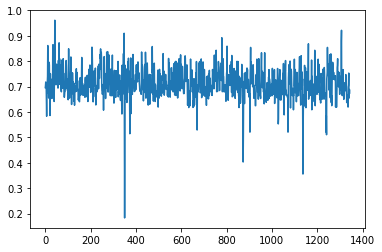

In [53]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [54]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Creation of Model

In [55]:
model = Sequential()

In [56]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [57]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [58]:
warmup_steps = 50

In [59]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [60]:
optimizer = RMSprop(lr=1e-3)

In [61]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         794112    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 794,625
Trainable params: 794,625
Non-trainable params: 0
_________________________________________________________________


In [63]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [64]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=6, verbose=1)

In [65]:
callback_tensorboard = TensorBoard(log_dir=".\\23_logs\\",
                                   histogram_freq=0,
                                   write_graph=False)

In [66]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-3,
                                       patience=0,
                                       verbose=1)

In [67]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [68]:
model.fit(x=generator,
          epochs=100,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

  ...
    to  
  ['...']
Train for 100 steps, validate on 1 samples
Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0070
Epoch 00001: val_loss improved from inf to 0.00435, saving model to 23_checkpoint.keras
100/100 [==============================] - 34s 343ms/step - loss: 0.0070 - val_loss: 0.0043
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0060
Epoch 00002: val_loss improved from 0.00435 to 0.00380, saving model to 23_checkpoint.keras
100/100 [==============================] - 31s 313ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0057
Epoch 00003: val_loss did not improve from 0.00380

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
100/100 [==============================] - 31s 311ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0054
Epoch 00004: val_loss did not improve from 0.003

In [69]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
'str' object has no attribute 'decode'


In [70]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 67ms/sample - loss: 0.0038


In [71]:
print("loss (test-set):", result)

loss (test-set): 0.0037971765268594027


In [72]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

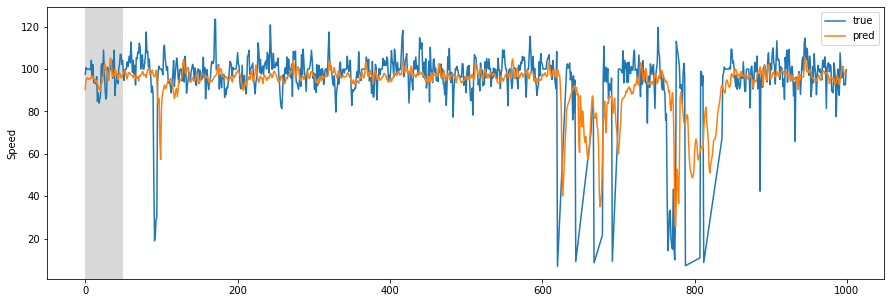

In [73]:
plot_comparison(start_idx=10000, length=1000, train=True)

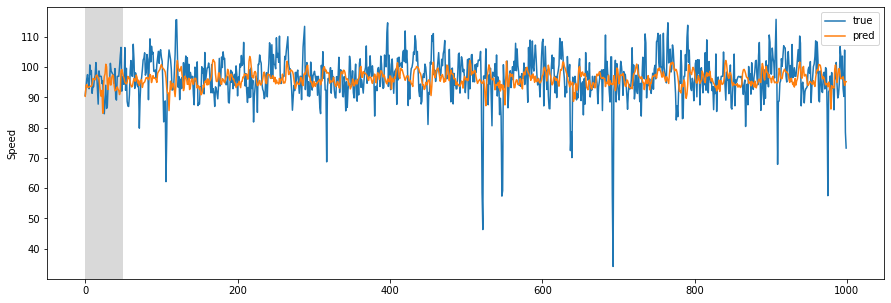

In [74]:
plot_comparison(start_idx=0, length=1000, train=False)